In [101]:
%reload_ext autoreload
%autoreload 2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard

import numpy as np
import h5py

from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import os, sys, time, random

from importlib import reload

import fidle

from myutils.dataset import  read_dataset, get_data_generator_v1, labels_to_class_name
from myutils.models import get_model_v1, get_model_v4
from myutils.tracking import get_callbacks

In [102]:
enhanced_dir = './data-0.5-scale'

dataset_name  = 'set-24x24-L'
batch_size    = 64
epochs        = 20
scale         = 1
fit_verbosity = 1

run_dir ='./track-aug-1-scale'

In [103]:
x_train,y_train,x_test,y_test,labels = read_dataset(enhanced_dir, dataset_name)
x_train,y_train, x_test,y_test = fidle.utils.rescale_dataset(x_train,y_train,x_test,y_test, scale=scale)

Datasets have been shuffled.
Datasets have been resized with a factor  1


Callbacks

Data generator

In [104]:
datagen = get_data_generator_v1()
datagen.fit(x_train)

In [105]:
(n,lx,ly,lz) = x_train.shape
print("Images of the dataset have this folowing shape : ",(lx,ly,lz))

Images of the dataset have this folowing shape :  (24, 24, 1)


In [106]:
model = get_model_v4(lx,ly,lz)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [107]:
chrono=fidle.Chrono()
chrono.start()

history = model.fit(  datagen.flow(x_train, y_train, batch_size=batch_size),
                      steps_per_epoch = int(x_train.shape[0]/batch_size),
                      epochs=epochs,
                      verbose=fit_verbosity,
                      validation_data=(x_test, y_test),
                      callbacks= get_callbacks(run_dir) )

model.save(f'{run_dir}/models/last-model.h5')

chrono.show()

Epoch 1/20


2023-12-29 00:43:17.064586: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 3s 287ms/step - loss: 3.7039 - accuracy: 0.2425 - val_loss: 3.6447 - val_accuracy: 0.0359
Epoch 2/20
10/10 [==============================] - 3s 278ms/step - loss: 2.8366 - accuracy: 0.3621 - val_loss: 3.6962 - val_accuracy: 0.1138
Epoch 3/20
10/10 [==============================] - 2s 207ms/step - loss: 2.5820 - accuracy: 0.3721 - val_loss: 4.2511 - val_accuracy: 0.1377
Epoch 4/20
10/10 [==============================] - 3s 281ms/step - loss: 2.3098 - accuracy: 0.4219 - val_loss: 5.3722 - val_accuracy: 0.1377
Epoch 5/20
10/10 [==============================] - 2s 233ms/step - loss: 2.1144 - accuracy: 0.4535 - val_loss: 6.1638 - val_accuracy: 0.1377
Epoch 6/20
10/10 [==============================] - 2s 224ms/step - loss: 1.9129 - accuracy: 0.4934 - val_loss: 7.1923 - val_accuracy: 0.1377
Epoch 7/20
10/10 [==============================] - 2s 226ms/step - loss: 1.7987 - accuracy: 0.5332 - val_loss: 7.6977 - val_accuracy: 0.1377
Epoch 8/20
10/10 

In [108]:
max_val_accuracy = max(history.history["val_accuracy"])
print("Max validation accuracy is : {:.4f}".format(max_val_accuracy))

Max validation accuracy is : 0.1377


In [109]:
score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss      : {:5.4f}'.format(score[0]))
print('Test accuracy  : {:5.4f}'.format(score[1]))

Test loss      : 11.4584
Test accuracy  : 0.1377


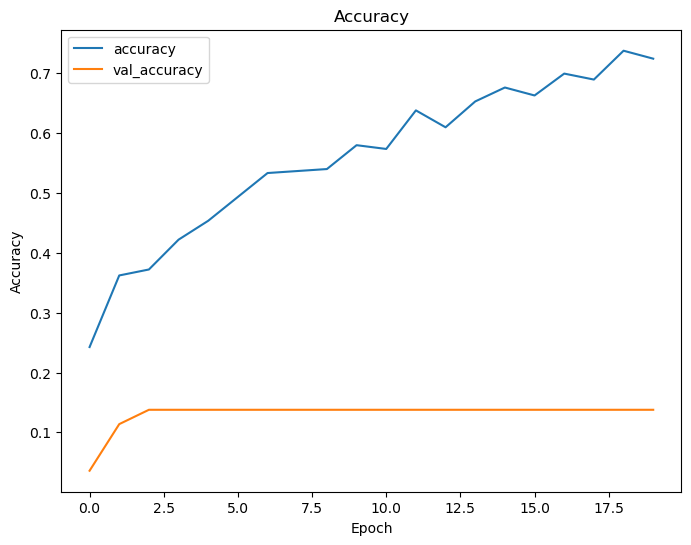

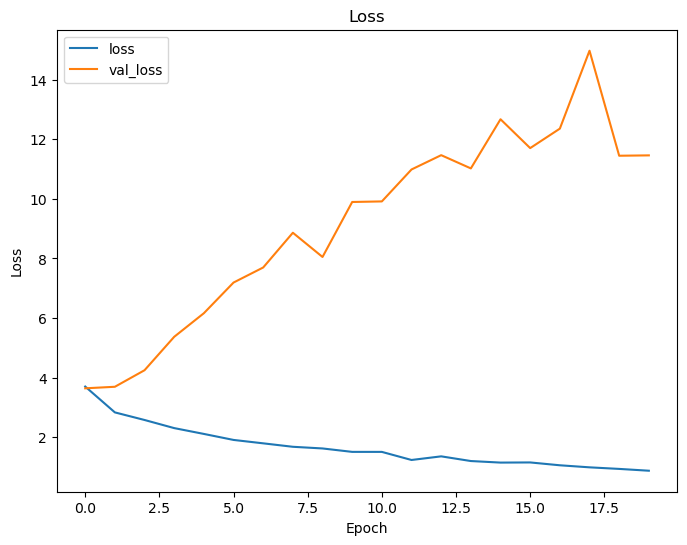

In [110]:
fidle.scrawler.history(history, save_as='01-history')

Evaluate best model

In [111]:
loaded_model = tf.keras.models.load_model(f'{run_dir}/models/best-model.h5')
# best_model.summary()
print("Loaded.")

Loaded.


In [112]:
score = loaded_model.evaluate(x_test, y_test, verbose=0)

print('Test loss      : {:5.4f}'.format(score[0]))
print('Test accuracy  : {:5.4f}'.format(score[1]))

Test loss      : 11.4463
Test accuracy  : 0.1377


6/6 [==============================] - 0s 19ms/step


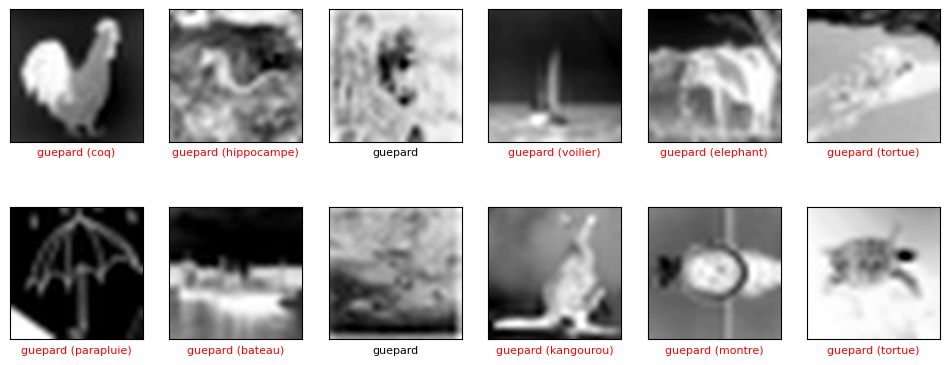

In [113]:

softmax_output = loaded_model.predict(x_test)
y_pred = np.argmax(softmax_output,axis=1)

samples = [ random.randint(0,len(x_test)-1) for i in range(12)]
fidle.scrawler.images(x_test,labels_to_class_name(labels,y_test),indices=samples,columns=6,x_size=2, y_size=2,fontsize=8,y_pred=labels_to_class_name(labels,y_pred))

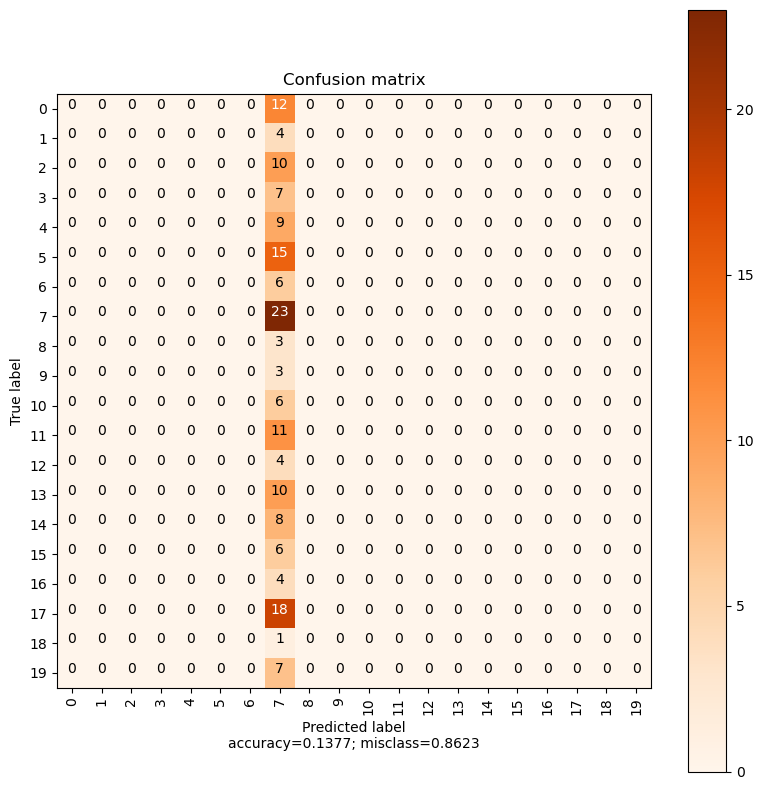

In [114]:
cmap = plt.get_cmap('Oranges')
fidle.scrawler.confusion_matrix(y_test,y_pred,range(20), figsize=(8, 8),normalize=False, cmap=cmap, save_as='02-confusion-matrix')